# Libraries

In [3]:
import pandas as pd
import numpy as np 
import plotly.express as px
import plotly.graph_objects as go
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm 
import os
import warnings
warnings.filterwarnings("ignore")
import re

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.manifold import TSNE

In [4]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(context = 'talk',  
              style = 'darkgrid',  
              font = 'Malgun Gothic', 
              font_scale = 1.2,         
              rc = custom_params) 

# Read the Data

In [5]:
cur_dir = os.getcwd()

for roots, dirs, files in os.walk(cur_dir):
    if ".git" not in roots:
        print(roots, files)

c:\Users\user\Documents\ML ['.gitignore', 'company.ipynb', 'graph.txt', 'Missing_values.ipynb', 'ml_Heart_Mine.ipynb', 'pre.txt', '분석기법별 특징.png']
c:\Users\user\Documents\ML\.vscode ['settings.json']
c:\Users\user\Documents\ML\data ['bestsellers with categories.csv', 'Book_description.npy', 'Companies_Dataset.csv', 'Companies_Dataset.xlsx', 'heart_disease_uci.csv']


In [6]:
data_list = os.listdir(cur_dir + "\data")
Dataset = {}

for data in data_list:
    if '.csv' in data:
        Dataset[data[:-4]] = pd.read_csv(cur_dir + f"\data\{data}")

In [7]:
cd = Dataset['Companies_Dataset']

In [8]:
df = cd.copy()

# Data info

In [9]:
na_count = df.isna().sum().reset_index()
dtypes_df = df.dtypes.reset_index()
unique_count = df.nunique().reset_index()

df_info = pd.merge(na_count, unique_count, on = "index", how = "left")
df_info = pd.merge(df_info, dtypes_df, on = "index", how = "left")

df_info = df_info.rename(columns = {"index":"col", "0_x":"null_count", "0_y":"unique_count", 0:"dtypes"})
df_info['null_ratio'] = round(df_info['null_count'] / len(df) * 100, 2)
df_info = df_info[['col', 'null_count', 'null_ratio', 'unique_count', 'dtypes']]

print(f"전체\n\nIndex: {df.shape[0]}개\nColumns: {df.shape[1]}개")
df_info

전체

Index: 197개
Columns: 10개


,col,null_count,null_ratio,unique_count,dtypes
0,Company Name,0,0.00,197,object
1,Company Rating,0,0.00,17,float64
2,Review Count,0,0.00,78,object
3,Company Sector,0,0.00,41,object
4,Company Type,43,21.83,6,object
5,No. of Employees,0,0.00,6,object
6,Company Age,2,1.02,85,object
7,Company Headquarters,0,0.00,192,object
8,Highly rated For,0,0.00,64,object
9,Poorly rated For,133,67.51,11,object


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Company Rating,197.0,3.974619,0.257669,3.1,3.8,4.0,4.1,4.8


In [11]:
df.head()

,Company Name,Company Rating,Review Count,Company Sector,Company Type,No. of Employees,Company Age,Company Headquarters,Highly rated For,Poorly rated For
0,TCS,3.8,71.9k,IT Services & Consulting,Public,1 Lakh+,56 years old,Varanasi +335 more,"Job Security, Work Life Balance","Promotions / Appraisal, Salary & Benefits"
1,Accenture,4.0,45.5k,IT Services & Consulting,Public,1 Lakh+,35 years old,Varanasi +166 more,"Company Culture, Job Security, Skill Developme...",NaN
2,Cognizant,3.9,41k,IT Services & Consulting,Forbes Global 2000,1 Lakh+,30 years old,Varanasi +153 more,Skill Development / Learning,Promotions / Appraisal
3,Wipro,3.8,36.3k,IT Services & Consulting,Public,1 Lakh+,79 years old,Varanasi +268 more,Job Security,"Promotions / Appraisal, Salary & Benefits"
4,HDFC Bank,3.9,33.3k,Banking,Public,1 Lakh+,30 years old,Varanasi +1513 more,"Job Security, Skill Development / Learning",Promotions / Appraisal


# EDA

## columns 수정

### column name

In [12]:
df.columns

Index(['Company Name', 'Company Rating', 'Review Count', 'Company Sector',
       'Company Type', 'No. of Employees', 'Company Age',
       'Company Headquarters', 'Highly rated For', 'Poorly rated For'],
      dtype='object')

In [13]:
def df_column(values):
    q = re.sub('\s', '_', values.lower())
    return q

new_col = []
for col in df.columns:
    new_col.append(df_column(col))

df.columns = new_col
df.head(1)

,company_name,company_rating,review_count,company_sector,company_type,no._of_employees,company_age,company_headquarters,highly_rated_for,poorly_rated_for
0,TCS,3.8,71.9k,IT Services & Consulting,Public,1 Lakh+,56 years old,Varanasi +335 more,"Job Security, Work Life Balance","Promotions / Appraisal, Salary & Benefits"


### column type

In [14]:
df.review_count

0      71.9k
1      45.5k
2        41k
3      36.3k
4      33.3k
       ...  
192     2.6k
193     2.6k
194     2.5k
195     2.5k
196     2.5k
Name: review_count, Length: 197, dtype: object

In [15]:
def review_count(values):
    if 'k' in values:
        return int(float(values.replace('k','')) * 1000)
    return values

In [16]:
df.review_count = df.review_count.apply(review_count)

> review_count

In [17]:
df['no._of_employees'].value_counts()

no._of_employees
10k-50k       111
5k-10k         34
1 Lakh+        24
1k-5k          14
50k-1 Lakh     13
201-500         1
Name: count, dtype: int64

In [18]:
def noof(values):
    if values == '201-500':
        return 0
    elif values == '1k-5k':
        return 1
    elif values == '5k-10k':
        return 2
    elif values == '10k-50k':
        return 3
    elif values == '50k-1 Lakh':
        return 4
    return 5

In [19]:
df['no._of_employees'] = df['no._of_employees'].apply(noof)

> no._of_employees

In [20]:
df.company_age

0       56 years old 
1       35 years old 
2       30 years old 
3       79 years old 
4       30 years old 
            ...      
192     27 years old 
193     24 years old 
194     94 years old 
195     92 years old 
196     36 years old 
Name: company_age, Length: 197, dtype: object

In [21]:
def comage(values):
    try:
        return float(re.sub('\D', '', values))  
    except:
        return values    

In [22]:
df.company_age = df.company_age.apply(comage)

> company_age

In [23]:
def headquaters(values):
    try:
        return int(re.sub('\D', '', values))  
    except:
        return values

In [24]:
df.company_headquarters = df.company_headquarters.apply(headquaters)

> head_quarters

In [25]:
df.company_type.value_counts()

company_type
 Public                 100
 Forbes Global 2000      21
 Fortune India 500       19
 Conglomerate             7
 Indian Unicorn           6
 Startup                  1
Name: count, dtype: int64

In [26]:
def comtype(values):
    try:
        if 'Public' in values:
            return 'pub'
        return 'pri'
    
    except:
        return values

In [27]:
df.company_type = df.company_type.apply(comtype)

> company_type

In [28]:
df.highly_rated_for.value_counts()

highly_rated_for
Job Security                                                     21
Job Security, Skill Development / Learning, Company Culture      14
Job Security, Work Life Balance, Company Culture                 10
Job Security, Company Culture, Work Life Balance                  9
Promotions / Appraisal, Salary & Benefits, Work Satisfaction      8
                                                                 ..
Skill Development / Learning, Job Security                        1
Work Life Balance, Job Security, Skill Development / Learning     1
Company Culture, Salary & Benefits, Work Life Balance             1
Job Security, Work Life Balance, Skill Development / Learning     1
Work Life Balance, Promotions / Appraisal, Work Satisfaction      1
Name: count, Length: 64, dtype: int64

> highly_rated_for << 원핫인코딩

In [29]:
df.head(3)

,company_name,company_rating,review_count,company_sector,company_type,no._of_employees,company_age,company_headquarters,highly_rated_for,poorly_rated_for
0,TCS,3.8,71900,IT Services & Consulting,pub,5,56.0,335,"Job Security, Work Life Balance","Promotions / Appraisal, Salary & Benefits"
1,Accenture,4.0,45500,IT Services & Consulting,pub,5,35.0,166,"Company Culture, Job Security, Skill Developme...",NaN
2,Cognizant,3.9,41000,IT Services & Consulting,pri,5,30.0,153,Skill Development / Learning,Promotions / Appraisal


# EDA 시각화

## num

In [30]:
df_num = df.select_dtypes(include = 'number')
df_num.head(2)

,company_rating,review_count,no._of_employees,company_age,company_headquarters
0,3.8,71900,5,56.0,335
1,4.0,45500,5,35.0,166


In [31]:
for col in df_num.columns:    
    fig = px.histogram(df[col],
                       marginal = 'rug',
                       nbins = df[col].nunique(),
                       color_discrete_sequence = ["#3F72AF"])
    fig.update_layout(title = col, bargap = 0.1)
    fig.show()

In [56]:
df_mer = df_num.join(pd.DataFrame(df.company_type))
df_mer.head(2)

,company_rating,review_count,no._of_employees,company_age,company_headquarters,company_type
0,3.8,71900,5,56.0,335,pub
1,4.0,45500,5,35.0,166,pub


In [64]:
fig = px.histogram(data_frame = df_mer['company_rating'],
                   nbins = df_mer['company_rating'].nunique(),
                   marginal = 'box',
                   color = df_mer['company_type'],)
fig.update_layout(title = "company_rating", bargap = 0.1)
fig.show()

## cat

In [33]:
df_cat = df.select_dtypes(include = 'object').drop(columns = 'company_name')
df_cat.head(2)

,company_sector,company_type,highly_rated_for,poorly_rated_for
0,IT Services & Consulting,pub,"Job Security, Work Life Balance","Promotions / Appraisal, Salary & Benefits"
1,IT Services & Consulting,pub,"Company Culture, Job Security, Skill Developme...",NaN


In [34]:
for col in df_cat.columns:    
    fig = px.histogram(data_frame = df_cat[col],
                       marginal = 'box',
                       color_discrete_sequence = ["#3F72AF"],
                       nbins = df_cat[col].nunique())
    fig.update_layout(title = col, bargap = 0.1)
    fig.show()

<Axes: >

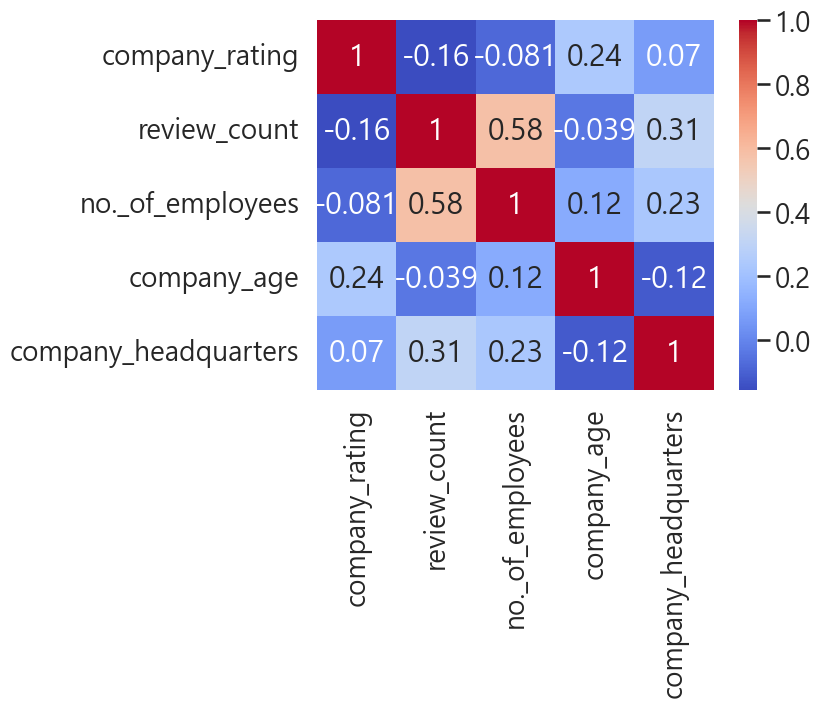

In [35]:
sns.heatmap(df_num.corr(), cmap = "coolwarm", annot = True)

# model

## mkTarget

In [36]:
df.company_rating.describe()

count    197.000000
mean       3.974619
std        0.257669
min        3.100000
25%        3.800000
50%        4.000000
75%        4.100000
max        4.800000
Name: company_rating, dtype: float64

In [37]:
fig = px.histogram(df.company_rating,
                   marginal = 'box',
                   nbins = df.company_rating.nunique())

fig.update_layout(title = 'rating', bargap = 0.1)
fig.show()

In [38]:
def mktarget(values):
    if values >= df.company_rating.median():
        return 1
    return 0

In [39]:
df.company_rating = df.company_rating.apply(mktarget)

In [40]:
means = df.company_age.mean()
df.company_age.fillna(means, inplace = True)

In [41]:
na_count = df.isna().sum().reset_index()
dtypes_df = df.dtypes.reset_index()
unique_count = df.nunique().reset_index()

df_info = pd.merge(na_count, unique_count, on = "index", how = "left")
df_info = pd.merge(df_info, dtypes_df, on = "index", how = "left")

df_info = df_info.rename(columns = {"index":"col", "0_x":"null_count", "0_y":"unique_count", 0:"dtypes"})
df_info['null_ratio'] = round(df_info['null_count'] / len(df) * 100, 2)
df_info = df_info[['col', 'null_count', 'null_ratio', 'unique_count', 'dtypes']]

print(f"전체\n\nIndex: {df.shape[0]}개\nColumns: {df.shape[1]}개")
df_info

전체

Index: 197개
Columns: 10개


,col,null_count,null_ratio,unique_count,dtypes
0,company_name,0,0.00,197,object
1,company_rating,0,0.00,2,int64
2,review_count,0,0.00,78,int64
3,company_sector,0,0.00,41,object
4,company_type,43,21.83,2,object
5,no._of_employees,0,0.00,6,int64
6,company_age,0,0.00,86,float64
7,company_headquarters,0,0.00,167,int64
8,highly_rated_for,0,0.00,64,object
9,poorly_rated_for,133,67.51,11,object


## train, test

In [42]:
X = df.drop(columns={'company_name', 'company_rating', 'company_type', 'company_sector', 'poorly_rated_for'})
y = df['company_rating']

In [43]:
encoder = OneHotEncoder(sparse=False)
encoded_x = encoder.fit_transform(X.select_dtypes(include = 'object'))

for col in X.columns:
    if df[col].dtypes == 'O':
        encoded_col = encoder.fit_transform(X[[col]])
        for i in range(encoded_col.shape[1]):
            X[f'{col}_encoded_{i}'] = encoded_col[:, i]
        X = X.drop(columns = col)
    else:
        pass

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = 777)

## model

### decision tree

In [45]:
dt = DecisionTreeClassifier(max_depth = 10, random_state = 777)
dt.fit(X_train, y_train)

# predict the test data
y_pred_dt = dt.predict(X_test)

print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.80      0.53      0.64        15
           1       0.77      0.92      0.84        25

    accuracy                           0.78        40
   macro avg       0.78      0.73      0.74        40
weighted avg       0.78      0.78      0.76        40



### random forest

In [46]:
rf = RandomForestClassifier(n_estimators=3000, random_state = 777)
rf.fit(X_train, y_train)

# predict the test data
y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.80      0.53      0.64        15
           1       0.77      0.92      0.84        25

    accuracy                           0.78        40
   macro avg       0.78      0.73      0.74        40
weighted avg       0.78      0.78      0.76        40



### support vector machine

In [47]:
svm = SVC(random_state=777)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       1.00      0.07      0.12        15
           1       0.64      1.00      0.78        25

    accuracy                           0.65        40
   macro avg       0.82      0.53      0.45        40
weighted avg       0.78      0.65      0.54        40



### xgboost

In [48]:
xgb = XGBClassifier(n_estimators = 100, random_state = 777)
xgb.fit(X_train, y_train)

y_pred_xg = xgb.predict(X_test)

print(classification_report(y_test, y_pred_xg))

              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.78      0.84      0.81        25

    accuracy                           0.75        40
   macro avg       0.74      0.72      0.73        40
weighted avg       0.75      0.75      0.75        40



# Model 평가

In [49]:
tmodel = TSNE(n_components=2)
x_embed = tmodel.fit_transform(X_test)

## decision tree

In [50]:
print(classification_report(y_test, y_pred_dt))
fig = px.scatter(x_embed[:,0],x_embed[:,1],color=y_test, symbol=y_test, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig.show()

px.scatter(x_embed[:,0],x_embed[:,1],color=y_pred_dt, symbol=y_pred_dt, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')

              precision    recall  f1-score   support

           0       0.80      0.53      0.64        15
           1       0.77      0.92      0.84        25

    accuracy                           0.78        40
   macro avg       0.78      0.73      0.74        40
weighted avg       0.78      0.78      0.76        40



## random forest

In [51]:
print(classification_report(y_test, y_pred_rf))
fig = px.scatter(x_embed[:,0],x_embed[:,1],color=y_test, symbol=y_test, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig.show()

px.scatter(x_embed[:,0],x_embed[:,1],color=y_pred_rf, symbol=y_pred_rf, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')

              precision    recall  f1-score   support

           0       0.80      0.53      0.64        15
           1       0.77      0.92      0.84        25

    accuracy                           0.78        40
   macro avg       0.78      0.73      0.74        40
weighted avg       0.78      0.78      0.76        40



## SVM

In [52]:
print(classification_report(y_test, y_pred_svm))
fig = px.scatter(x_embed[:,0],x_embed[:,1],color=y_test, symbol=y_test, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig.show()

px.scatter(x_embed[:,0],x_embed[:,1],color=y_pred_svm, symbol=y_pred_svm, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')

              precision    recall  f1-score   support

           0       1.00      0.07      0.12        15
           1       0.64      1.00      0.78        25

    accuracy                           0.65        40
   macro avg       0.82      0.53      0.45        40
weighted avg       0.78      0.65      0.54        40



## xgboost

In [53]:
print(classification_report(y_test, y_pred_xg))
fig = px.scatter(x_embed[:,0],x_embed[:,1],color=y_test, symbol=y_test, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig.show()

px.scatter(x_embed[:,0],x_embed[:,1],color=y_pred_xg, symbol=y_pred_xg, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')

              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.78      0.84      0.81        25

    accuracy                           0.75        40
   macro avg       0.74      0.72      0.73        40
weighted avg       0.75      0.75      0.75        40

